# What is the True Normal Human Body Temperature? 

#### Background

The mean normal body temperature was held to be 37$^{\circ}$C or 98.6$^{\circ}$F for more than 120 years since it was first conceptualized and reported by Carl Wunderlich in a famous 1868 book. But, is this value statistically correct?

We will examine a dataset taken from Mackowiak, P. A., Wasserman, S. S., and Levine, M. M.  (1992), "A Critical Appraisal of 98.6 Degrees F, the Upper Limit of the Normal Body Temperature, and Other Legacies of Carl Reinhold August Wunderlich," _Journal of the American Medical Association_, 268, 1578-1580. 

A summary is provided at https://ww2.amstat.org/publications/jse/datasets/normtemp.txt.

<h3>Plan</h3>

<p>We will analyze the dataset and employ the concepts of hypothesis testing, confidence intervals, and statistical significance using frequentist, bootstrap and permutation methods. We set out to answer the following questions.</p> 

<ol>
<li>  Is the distribution of body temperatures normal? 
<li>  Is the sample size large? Are the observations independent?
<li>  Is the true population mean really 98.6 degrees F?
<li>  Should we use z or t-tests?
<li>  Do different tests give significantly different results?
<li>  What about different sample sizes?
<li>  At what temperature should we consider someone's temperature to be "abnormal"?
<li>  Is there a significant difference between males and females in normal temperature?

## Import Libraries

In [4]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

## Open Dataset

In [5]:
df = pd.read_csv('data/human_body_temperature.csv')

## Check Data

In [6]:
df.shape

(130, 3)

130 rows is not substantial, so we will have to be careful using statistics.

In [7]:
df.describe()

,temperature,heart_rate
count,130.000000,130.000000
mean,98.249231,73.761538
std,0.733183,7.062077
min,96.300000,57.000000
25%,97.800000,69.000000
50%,98.300000,74.000000
75%,98.700000,79.000000
max,100.800000,89.000000


Note that the median is 98.25, and the mean is 98.3, both less than 98.6. The proximity of mean and median imply a normal distribution.

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 130 entries, 0 to 129
Data columns (total 3 columns):
temperature    130 non-null float64
gender         130 non-null object
heart_rate     130 non-null float64
dtypes: float64(2), object(1)
memory usage: 3.1+ KB


Confirms that the temperature column is a float.

In [9]:
df.head()

,temperature,gender,heart_rate
0,99.3,F,68.0
1,98.4,F,81.0
2,97.8,M,73.0
3,99.2,F,66.0
4,98.0,F,73.0


Could males and females have different mean temperatures? We will explore this later on.

## Temperature Graphs

In [10]:
import seaborn as sns
sns.set()

I like using seaborn because of the background grid.

### Histogram

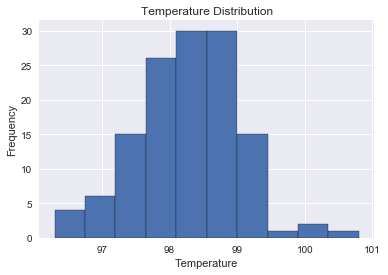

In [11]:
# Plot the histogram with default number of bins.
_= plt.hist(df['temperature'], edgecolor='k')
_= plt.xlabel('Temperature')
_= plt.ylabel('Frequency')
_= plt.title('Temperature Distribution')

# Show the plot
plt.show()

This is close to a normal distribution, although more data points are to the left.

### CDF

In [129]:
#Provides the paramaters to plot a cdf
def ecdf(data):
    """Compute ECDF for a one-dimensional array of measurements."""

    # Number of data points: n
    n = len(data)

    # x-data for the ECDF: x
    x = np.sort(data)

    # y-data for the ECDF: y
    y = np.arange(1, n+1) / n

    return x, y

In [148]:
# Function to plot cdf and compare to normal distribution
def graph_ecdf(data):
    x, y = ecdf(data)

    # Generate plot
    plt.plot(x, y, marker='.', linestyle='none')

    # Make the margins nice
    plt.margins(.02)

    # Label the axes
    plt.xlabel('Temperature')
    plt.ylabel('ECDF')
    plt.title('Temperature Cumulative Distribution')
    
    #Compare with normal distribution of data
    mean = np.mean(data)
    std = np.std(data)
    samples = np.random.normal(mean, std, size=10000)
    x_theor, y_theor = ecdf(samples)
    plt.plot(x_theor, y_theor)
    

    #Show the plot
    plt.show()

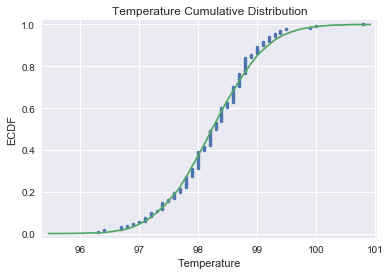

In [149]:
#Graph function using our data
graph_ecdf(df.temperature)

That is beautifully normal! It appears there may be a few more data points to the left. Note that the CDF is generally a better test for normality since it does not rely on the number of bins.

In [14]:
df[df['temperature'] < df['temperature'].median()].count()

temperature    64
gender         64
heart_rate     64
dtype: int64

Data points to the left of the median are very close to exactly half. For comparison, we can check data points to the right. 

In [15]:
df[df['temperature'] > df['temperature'].median()].count()

temperature    61
gender         61
heart_rate     61
dtype: int64

In [16]:
df[df['temperature'] == df['temperature'].median()].count()

temperature    5
gender         5
heart_rate     5
dtype: int64

Including the 5 points equal to the median, they sum to 130 as expected. The graph is not skewed. We can proceed assuming that our data is approximately normal.

## Independence

We can assume independence since the body temperature of 1 individual presumably has no effect on another.

## Large Counts

Since we have 130>30 samples, the Central Limit Theorem Applies. (Note that our distribution is approximatley normal, so the CLT would apply even if n<30.)

## Hypothesis Tests

Our null hypothesis is that the mean human body temperature is 98.6 as stated by Wunderlich. We will investigate this claim starting with a bootstrap test.

## Bootstrap Test

Bootstrapping means that we will resample our data with replacement and compute the mean each time.

### Define Bootstrap Functions

In [17]:
#Returns the result of a function, like np.mean
def bootstrap_replicate_1d(data, func):
    return func(np.random.choice(data, size=len(data)))

#Produces desired function, like np.mean, for all replicants of size=x
def draw_bs_reps(data, func, size=1):
    """Draw bootstrap replicates."""

    # Initialize array of replicates: bs_replicates
    bs_replicates = np.empty(size)

    # Generate replicates
    for i in range(size):
        bs_replicates[i] = bootstrap_replicate_1d(data, func)

    return bs_replicates

### Bootstrap Temperature Mean

SEM:  0.06405661469519336
STD:  0.0635160125689791


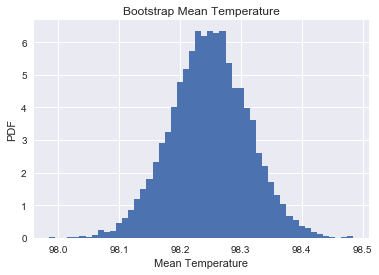

Given our sample, the proability that the mean temperature is 98.6 is  0.0


In [18]:
# Take 10,000 bootstrap replicates of the mean: bs_replicates
bs_replicates = draw_bs_reps(df.temperature, np.mean, size=10000)

# Compute and print SEM (Standard Error of the Mean)
sem = np.std(df.temperature) / np.sqrt(len(df.temperature))
print("SEM: ", sem)

# Compute and print standard deviation of bootstrap replicates
bs_std = np.std(bs_replicates)
print("STD: ", bs_std)

# Make a histogram of the results
_ = plt.hist(bs_replicates, bins=50, normed=True)
_ = plt.xlabel('Mean Temperature')
_ = plt.ylabel('PDF')
_ = plt.title('Bootstrap Mean Temperature')

# Show the plot
plt.show()

#Find the probability of 98.6
p = np.sum(bs_replicates >= 98.6) / len(bs_replicates)
print('Given our sample, the proability that the mean temperature is 98.6 is ', p)

Extraordinary! But how confident are we that the mean presented in the histogram above is accurate?

### Bootstrap Confidence Interval

In [ ]:
# Function to Compute Confidence Interval
def confidence_Interval(percent, data):
    split_percent = (100-percent)/2
    return np.percentile(data,[split_percent, percent + split_percent])

In [51]:
# This is a 99% Confidence Interval
ci = confidence_Interval(99, bs_replicates)
print("We are 99% confident that the range of ", ci, " captures the true mean.")

We are 99% confident that the range of  [98.08153462 98.41154231]  captures the true mean.


Since 98.6 falls outside of the 99% Confidence Interval, we reject the null hypothesis. The true mean is not 98.6.

## Frequentist Temperature Mean

Let's try the same approach using frequentist methods. Since we do not know the standard deviation of the population, a one-sample t-test is warranted.

### Define t-score / p-value functions

In [20]:
#tscore function for mean
def tscore_mean(statistic, parameter, size):
    tscore = (statistic - parameter.mean())/(parameter.std()/size**0.5)
    return tscore

#convert tscore to p-value
def pvalue_fromt(tscore, size):
    import scipy.stats as stats
    #assumes 2-sided t-value
    pvalue = stats.t.sf(tscore, (size-1))*2
    return pvalue

### Compute t-score / p-value

In [23]:
tscore = tscore_mean(98.6, df.temperature, 130)
p = pvalue_fromt(tscore, 130)
print('t-score: ', tscore)
print('p-value: ', p)

t-score:  5.454823292364079
p-value:  2.4106320415609943e-07


The probability is very close to 0! Again, we convincingly reject the null hypothesis. According to our sample, there is a 0.00000024 percent chance that the mean temperature is 98.6.

Let's compare this result with the p-value we obtain from using a z-score. Since our sample size is above 30, the results should not significantly differ. 

### Define z-score / p-value functions

In [25]:
#zscore function for means
def zscore_mean(statistic, parameter, size=1):
    zscore = (statistic - parameter.mean())/(parameter.std()/size**0.5)
    return zscore

#convert zscore to p-value
def pvalue(zscore):
    import scipy.stats as stats
    prob = 1 - stats.norm.cdf(zscore)
    return prob

### Compute z-score / p-value

In [26]:
zscore = zscore_mean(98.6, df.temperature, 130)
p = pvalue(zscore)
print('z-score: ', zscore)
print('p-value: ', p)

z-score:  5.454823292364079
p-value:  2.451078506826576e-08


Very close to 0. Note that the p-value is less because a normal distribution has 0 degrees of freedom. 

## Sample Size of 10

If our sample size was only 10 subjects, we would likely obtain different results. Let's see just how different.

In [28]:
df_10 = df.sample(10)

In [30]:
df_10

,temperature,gender,heart_rate
101,98.5,M,68.0
76,98.0,F,76.0
42,96.9,M,74.0
5,99.2,M,83.0
14,97.8,F,77.0
21,98.2,M,71.0
15,98.8,F,83.0
75,98.8,M,78.0
129,98.7,F,59.0
93,97.1,M,73.0


In [34]:
df_10.describe()

,temperature,heart_rate
count,10.000000,10.000000
mean,98.200000,74.200000
std,0.757188,7.161626
min,96.900000,59.000000
25%,97.850000,71.500000
50%,98.350000,75.000000
75%,98.775000,77.750000
max,99.200000,83.000000


### t-Score

In [33]:
tscore = tscore_mean(98.6, df_10.temperature, 10)
p = pvalue_fromt(tscore, 10)
print('t-score: ', tscore)
print('p-value: ', p)

t-score:  1.6705381391690775
p-value:  0.129150170064759


The probability is no longer significant.

### z-score

In [36]:
zscore = zscore_mean(98.6, df_10.temperature, 10)
p = pvalue(zscore)
print('z-score: ', zscore)
print('p-value: ', p)

z-score:  1.6705381391690775
p-value:  0.04740647004897469


Although the z-score is significant at a 95% level, the test is not warranted since our sample size is less than 30. It's also unlikely to be normally distributed. We can check by graphing the ECDF.

### Check CDF

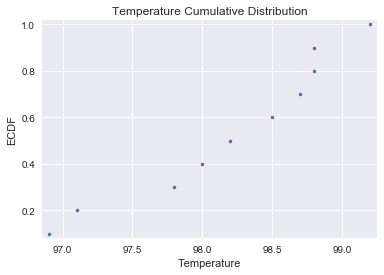

In [41]:
graph_ecdf(df_10.temperature)

It's the right general shape, but there's not enough data points to infer that it's normal.

## Abnormal Temperatures?

What is abnormal? It is standard practice to use 95% as a normal range. That number, however, is historical and somewhat arbitrary. I will consider both 95% and 99% ranges. We can call our Confidence Interval function, defined earlier, to generate these intervals.

### Frequentist Method

In [161]:
abnormal_temp = confidence_Interval(95, df.temperature)
print("Normal temps:", abnormal_temp, "in range 95%.")

Normal temps: [96.7225 99.4775] in range 95%.


In [162]:
abnormal_temp2 = confidence_Interval(99, df.temperature)
print("Normal temps:", abnormal_temp2, "in range 99%.")

Normal temps: [ 96.3645 100.284 ] in range 99%.


This is a little closer to the expected norm of 100 meaning someone has a fever.

### Bootstrap Method

In [163]:
bootstrap_data = np.random.choice(df.temperature, size=10000)
abnormal_temp_bs = confidence_Interval(95, bootstrap_data)
print("Normal temps:", abnormal_temp_bs, "in range 95%.")

Normal temps: [96.7 99.5] in range 95%.


This is very close to the actual data.

In [164]:
abnormal_temp2_bs = confidence_Interval(99, bootstrap_data)
print("Normal temps:", abnormal_temp2_bs, "in range 99.0%.")

Normal temps: [ 96.3 100.8] in range 99.0%.


Close, but the max norm appears a little high.

## Gender Difference?

Is there a difference in normal temperature between males and females? Let's analyze the data to find out.

### Explore Male/Female DataFrames

In [117]:
# Create DataFrames
df_male = df.loc[df.gender == 'M']
df_female = df.loc[df.gender == 'F']

In [120]:
df_male.describe()

,temperature,heart_rate
count,65.000000,65.000000
mean,98.104615,73.369231
std,0.698756,5.875184
min,96.300000,58.000000
25%,97.600000,70.000000
50%,98.100000,73.000000
75%,98.600000,78.000000
max,99.500000,86.000000


In [121]:
df_female.describe()

,temperature,heart_rate
count,65.000000,65.000000
mean,98.393846,74.153846
std,0.743488,8.105227
min,96.400000,57.000000
25%,98.000000,68.000000
50%,98.400000,76.000000
75%,98.800000,80.000000
max,100.800000,89.000000


In [122]:
df_male.shape

(65, 3)

In [123]:
df_female.shape

(65, 3)

### Graph Distributions

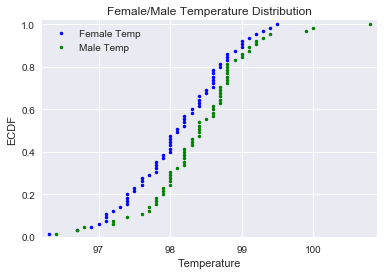

In [146]:
# Compute ECDF for versicolor data: x_vers, y_vers
x_f, y_f = ecdf(df_male.temperature)

# Generate plot
female_temp, = plt.plot(x_f, y_f, marker='.', linestyle='none', color='b', label='Female Temp')

# Compute ECDF for versicolor data: x_vers, y_vers
x_m, y_m = ecdf(df_female.temperature)

# Generate plot
male_temp, = plt.plot(x_m, y_m, marker='.', linestyle='none', color='g', label='Male Temp')

# Make the margins nice
plt.margins(.02)

# Label the axes
plt.xlabel('Temperature')
plt.ylabel('ECDF')
plt.title('Female/Male Temperature Distribution')
plt.legend(handles=[female_temp, male_temp])
plt.show()

The distributions are fairly close, and approximately normal. It's clear that the female subjects have a greater temperature on average, as confirmed by the mean in the dataframes above.

### Check Male/Female 99 Percentile Using Bootstrap Method

In [118]:
bootstrap_data_male = np.random.choice(df_male.temperature, size=10000)
abnormal_temp_bs_male = confidence_Interval(99, bootstrap_data_male)
print("Male normal temps:", abnormal_temp_bs_male, "in range 99%.")

Male normal temps: [96.3 99.5] in range 99%.


In [119]:
bootstrap_data_female = np.random.choice(df_female.temperature, size=10000)
abnormal_temp_bs_female = confidence_Interval(99, bootstrap_data_female)
print("Female normal temps:", abnormal_temp_bs_female, "in range 99%.")

Female normal temps: [ 96.4 100.8] in range 99%.


According to our sample, the range of normal temperatures for males and females are different, but is the difference significant? Since both distributions are approximately normal, we can answer this question by analyzing the mean. 

### Female / Male Mean Temps

In [152]:
print("Male Mean Temp: ", np.mean(df_male.temperature))
print("Female Mean Temp: ", np.mean(df_female.temperature))

Male Mean Temp:  98.1046153846154
Female Mean Temp:  98.39384615384613


This is nearly a difference of 0.3. Let's do a permutation test to see if the difference is by chance.

### Permutation Test

#### Required Functions

In [155]:
# Create permutation sample
def permutation_sample(data1, data2):
    """Generate a permutation sample from two data sets."""

    # Concatenate the data sets: data
    data = np.concatenate((data1, data2))

    # Permute the concatenated array: permuted_data
    permuted_data = np.random.permutation(data)

    # Split the permuted array into two: perm_sample_1, perm_sample_2
    perm_sample_1 = permuted_data[:len(data1)]
    perm_sample_2 = permuted_data[len(data1):]

    return perm_sample_1, perm_sample_2

# Create permutation replicates
def draw_perm_reps(data_1, data_2, func, size=1):
    """Generate multiple permutation replicates."""

    # Initialize array of replicates: perm_replicates
    perm_replicates = np.empty(size)

    for i in range(size):
        # Generate permutation sample
        perm_sample_1, perm_sample_2 = permutation_sample(data_1, data_2)

        # Compute the test statistic
        perm_replicates[i] = func(perm_sample_1, perm_sample_2)

    return perm_replicates

# Find difference of means
def diff_of_means(data_1, data_2):
    """Difference in means of two arrays."""

    # The difference of means of data_1, data_2: diff
    diff = np.mean(data_1)-np.mean(data_2)

    return diff

#### Compute Probability That Difference of Female/Male Temps is Due to Chance

In [160]:
# Compute difference of means
empirical_diff_means = diff_of_means(df_female.temperature, df_male.temperature)

# Draw 10,000 permutation replicates: perm_replicates
perm_replicates = draw_perm_reps(df_female.temperature, df_male.temperature,
                                 diff_of_means, size=10000)

# Compute p-value: p
p = np.sum(perm_replicates >= empirical_diff_means) / len(perm_replicates)

# Print the result
print('p-value =', p)

p-value = 0.0131


Of 10,000 samples, 0.0131 have a difference of mean greater than our sample. This is significant at the 95% level, but not quite at the 99% level. We can conclude that it's fairly likely the difference in normal temperatures is not due to chance.

## Conclusion

The results are stunning. It's very likely that the mean temperature of 96.8 passed down from Wunderlich in the 1800s is close to accurate, but wrong. It's also likely that females and males have different normal temperatures, although more data analysis is needed for confirmation.